###### Day 3 Data Preparation Outlier Detection.

In [1]:
# Coding as in Brownlee's Bk Data prep
# Some of the codes have been altered.

from numpy.random import seed
from numpy.random import randn
from numpy import mean
from numpy import std

seed(1)

# Now generate univariate observations
# The observations are a 1 dimension array

data = 5 * randn(10000) + 50
data.shape

# calcuating summary stats.
data_mean , data_std = mean(data), std(data)

# Defining outliers.
# outliers reside 3 std away from the mean

cut_off = 3 * data_std

lower, upper = data_mean - cut_off, data_mean + cut_off

# Now if the observations fall outside the range we can remove them.

outliers = [ x for x in data if x < lower or x > upper]
print("We Identified: %d"% len(outliers))

# Now to remove them 
outliers_removed = [ x for x in data if x >= lower and x<= upper]
print('Non-outlier observations: %d'% (len(data)-len(outliers)))
print('Non-outlier observations: %d'% len(outliers_removed))

for i in range(5):
    print(outliers[i])

    

We Identified: 29
Non-outlier observations: 9971
Non-outlier observations: 9971
65.15428556186015
69.79301352018982
66.60539378085183
34.73117809786848
34.23321274904475


Generally This approach is good and is commonly used.

##### InterQuartile Range Method.


In [2]:
# For the IQR method .
# The code is my implementation.
# an outlier is said to be one if it falls outside the
# range Q1 - 1.5 IQR TO Q3 + 1.5 * IQR.

# using the data above we can use the percentile fxn

from numpy import percentile

Q1 , Q3 = percentile( data, [25,75])

IQR = Q3 - Q1

upper, lower = Q3 + 1.5* IQR ,Q1 - 1.5 * IQR

outlier = [x for x in data if x > upper or x < lower]
print("Found the following: %d"% len(outlier))


Found the following: 81


##### Automatic Outlier Detection

In [3]:
from urllib.request import urlretrieve as ret
url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/housing.csv"
ret(url, "housing.csv")


('housing.csv', <http.client.HTTPMessage at 0x20aa98eee50>)

In [4]:
import pandas as pd
df = pd.read_csv(url, header=None)
df.head(5)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222.0,18.7,396.90,5.33,36.2


In [5]:
df.describe()
df.info()
# the dataset doesn't contain any missing values


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 14 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       506 non-null    float64
 1   1       506 non-null    float64
 2   2       506 non-null    float64
 3   3       506 non-null    int64  
 4   4       506 non-null    float64
 5   5       506 non-null    float64
 6   6       506 non-null    float64
 7   7       506 non-null    float64
 8   8       506 non-null    int64  
 9   9       506 non-null    float64
 10  10      506 non-null    float64
 11  11      506 non-null    float64
 12  12      506 non-null    float64
 13  13      506 non-null    float64
dtypes: float64(12), int64(2)
memory usage: 55.5 KB


In [6]:
# now detecting outliers.

from sklearn.model_selection import train_test_split

# retrieve the array.
data = df.values

# split the data
X, y = data[:, :-1], data[:, -1]

# summarise the shape of the data

print(X.shape, y.shape)

# split into train and test set
X_train, X_test, y_train, y_test = train_test_split(X, y ,
                                                   test_size=0.33, random_state=1)

# summarize the shahpe of the train and test sets.

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

# makes sense since we did slit the data.


(506, 13) (506,)
(339, 13) (167, 13) (339,) (167,)


In [7]:
# we fit a linear regression model and evaluate the predictions
# using MAE mean absolute error.
# the model was fit without first removing outliers.

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error

model = LinearRegression()
model.fit(X_train, y_train)

# evaluate the model.
yhat = model.predict(X_test)

mae = mean_absolute_error(y_test, yhat)
print("MAE: %.3f"% mae)

MAE: 3.417


(295, 13) (295,)
<class 'numpy.ndarray'> 295 True
(295, 13) (295,)
MAE: 3.371


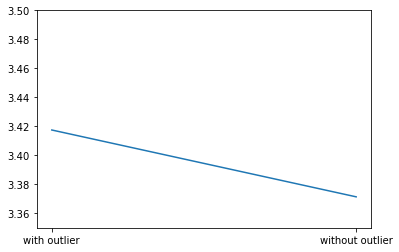

In [17]:
# now removing outliers.
from sklearn.neighbors import LocalOutlierFactor
print(X_train.shape, y_train.shape)
# identifying outliers in the training dataset

lof = LocalOutlierFactor()

yhat = lof.fit_predict(X_train)

# select all rows that are not outliers
mask = yhat != -1

print(type(mask), len(mask), mask[2])

# the mask ndarray contain true and false values 

X_train,y_train = X_train[mask, : ], y_train[mask]

# summarize the shape of the updated training dataset

print(X_train.shape, y_train.shape)

# fit the model
model = LinearRegression()
model.fit(X_train, y_train)



# nd evaluate the model

yhat = model.predict(X_test)

# evaluate predictions

mae1 = mean_absolute_error(y_test, yhat)

print("MAE: %.3f"% mae1)


# we can print a line graph to detect change in mae

from matplotlib import pyplot

x = ["with outlier","without outlier"] 
y = [mae, mae1]

pyplot.plot(x,y)
pyplot.ylim(3.35,3.5)
pyplot.show()

# we can see a small significant drop in mae.

In [9]:
mae

3.417472278801661